# **Part 1: Which customers should a call-center call for greater assertiveness in a sale?**

### Business Objectives
The objective is to predict which customers a call center should contact to close a sale.

## **Prepare Environment**

<br/>

### Imports

In [110]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno # missing values

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Other
from IPython.display import Image
import configparser
import warnings
import pprint
import os

<br/>

### Prepare Principal Directory

In [111]:
def path_to_work(end_directory: str='notebooks'):
    curr_dir = os.path.dirname(os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return f'Change directory to: {curr_dir}'
    
    return f'Current working directory: {curr_dir}'

In [112]:
path_to_work(end_directory='notebooks')

'Current working directory: /home/campos/projects/predict-which-customers-a-call-center-should-contact'

<br/>

### Set Config

In [113]:
# Visualization inside the jupyter
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## **Data Understanding**

### Collect Initial Data
The dataset to be explored was provided by [Keyrus](https://keyrus.com/worldwide/home)

### File Descriptions
- `callcenter_marketing.csv` - the dataset
- `callcenter_descricao.txt` - metadata, describe columns

## Load Data

In [18]:
%%time

df_callcenter = pd.read_csv('data/raw/callcenter_marketing.csv', 
                            encoding='utf8',
                            delimiter=',',
                            verbose=True)

Tokenization took: 51.66 ms
Type conversion took: 55.70 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 6.37 ms
Type conversion took: 19.62 ms
Parser memory cleanup took: 0.05 ms
CPU times: user 136 ms, sys: 29 ms, total: 165 ms
Wall time: 162 ms


---

## **Describe Data**

In [19]:
!cat data/callcenter_descricao.txt

O dataset fornece o resultado de uma campanha de marketing para cada usuário (sim - comprou / nao - não comprou)

Temos como variáveis:

Dados do cliente:
   1 - idade
   2 - profissao
   3 - estado_civil
   4 - educacao
   5 - inadimplente
   6 - emprestimo_moradia: possui empréstimo para moradia?
   7 - emprestimo_pessoal: possui empréstimo pessoal?
Dados relacionados com últimos contatos:
   8 - meio_contato: tipo de contato
   9 - mes: último mês de contato
  10 - dia_da_semana: último dia da semana de contato
  11 - duracao: última duração do contato, em segundos. Nota: este atributo causa overfitting no modelo.
Outras variáveis:
  12 - qtd_contatos_campanha: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  13 - dias_ultimo_contato: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  14 - qtd_contatos_total: number of contacts pe

---

## **Explore Data**

In [25]:
# Lists that will be manipulated in the data processing
list_columns = []
list_categorical_col = []
list_numerical_col = []

In [26]:
def get_col(df: pd.core.frame.DataFrame, type_descr: 'numpy') -> list:
    """
    Function get list columns 
    
    Args:
    type_descr
        np.number, np.object -> return list with all columns
        np.number            -> return list numerical columns 
        np.object            -> return list object columns
    """
    try:
        col = (df.describe(include=type_descr).columns) 
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n')    
    else:
        return col.tolist()

In [27]:
list_numerical_col = get_col(df=df_callcenter,
                             type_descr=np.number)
list_categorical_col = get_col(df=df_callcenter,
                               type_descr=np.object)
list_columns = get_col(df=df_callcenter,
                       type_descr=[np.object, np.number])

In [28]:
display(df_callcenter.head(10))

,Unnamed: 0,idade,profissao,estado_civil,educacao,inadimplente,emprestimo_moradia,emprestimo_pessoal,meio_contato,mes,dia_da_semana,duracao,qtd_contatos_campanha,dias_ultimo_contato,qtd_contatos_total,campanha_anterior,indice_precos_consumidor,indice_confianca_consumidor,euribor3m,numero_empregados,resultado
0,0,56,dona_casa,casado,fundamental_4a,nao,nao,nao,telefone,mai,seg,261,1,999,0,nao_existente,93.99,-36.40,4.86,5191.00,nao
1,1,57,servicos,casado,ensino_medio,NaN,nao,nao,telefone,mai,seg,149,1,999,0,nao_existente,93.99,-36.40,4.86,5191.00,nao
2,2,37,servicos,casado,ensino_medio,nao,sim,nao,telefone,mai,seg,226,1,999,0,nao_existente,93.99,-36.40,4.86,5191.00,nao
3,3,40,admin.,casado,fundamental_6a,nao,nao,nao,telefone,mai,seg,151,1,999,0,nao_existente,93.99,-36.40,4.86,5191.00,nao
4,4,56,servicos,casado,ensino_medio,nao,nao,sim,telefone,mai,seg,307,1,999,0,nao_existente,93.99,-36.40,4.86,5191.00,nao
5,5,45,servicos,casado,fundamental_9a,NaN,nao,nao,telefone,mai,seg,198,1,999,0,nao_existente,93.99,-36.40,4.86,5191.00,nao
6,6,59,admin.,casado,curso_tecnico,nao,nao,nao,telefone,mai,seg,139,1,999,0,nao_existente,93.99,-36.40,4.86,5191.00,nao
7,7,41,colarinho_azul,casado,NaN,NaN,nao,nao,telefone,mai,seg,217,1,999,0,nao_existente,93.99,-36.40,4.86,5191.00,nao
8,8,24,tecnico,solteiro,curso_tecnico,nao,sim,nao,telefone,mai,seg,380,1,999,0,nao_existente,93.99,-36.40,4.86,5191.00,nao
9,9,25,servicos,solteiro,ensino_medio,nao,sim,nao,telefone,mai,seg,50,1,999,0,nao_existente,93.99,-36.40,4.86,5191.00,nao


In [29]:
print("Dataframe:\n{} rows\n{} columns".format(df_callcenter.shape[0],
                                               df_callcenter.shape[1]))

Dataframe:
41188 rows
21 columns


#### Column Information
- Names
- Rows by columns
- Types of data in each column
- Dataframe format

In [30]:
list_columns = (df_callcenter.columns).tolist()

print("-"*25, "List Columns", "-"*25, end='\n')
display(list_columns)

------------------------- List Columns -------------------------


['Unnamed: 0',
 'idade',
 'profissao',
 'estado_civil',
 'educacao',
 'inadimplente',
 'emprestimo_moradia',
 'emprestimo_pessoal',
 'meio_contato',
 'mes',
 'dia_da_semana',
 'duracao',
 'qtd_contatos_campanha',
 'dias_ultimo_contato',
 'qtd_contatos_total',
 'campanha_anterior',
 'indice_precos_consumidor',
 'indice_confianca_consumidor',
 'euribor3m',
 'numero_empregados',
 'resultado']

**NOTE:** There are no blank spaces in column names

In [31]:
print(df_callcenter.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   41188 non-null  int64  
 1   idade                        41188 non-null  int64  
 2   profissao                    40858 non-null  object 
 3   estado_civil                 41108 non-null  object 
 4   educacao                     39457 non-null  object 
 5   inadimplente                 32591 non-null  object 
 6   emprestimo_moradia           40198 non-null  object 
 7   emprestimo_pessoal           40198 non-null  object 
 8   meio_contato                 41188 non-null  object 
 9   mes                          41188 non-null  object 
 10  dia_da_semana                41188 non-null  object 
 11  duracao                      41188 non-null  int64  
 12  qtd_contatos_campanha        41188 non-null  int64  
 13  dias_ultimo_cont

Neste momento não há necessidade de formatar as colunas para outros tipos de dados.

In [32]:
print(df_callcenter.nunique())

Unnamed: 0                     41188
idade                             78
profissao                         11
estado_civil                       3
educacao                           7
inadimplente                       2
emprestimo_moradia                 2
emprestimo_pessoal                 2
meio_contato                       2
mes                               10
dia_da_semana                      5
duracao                         1544
qtd_contatos_campanha             42
dias_ultimo_contato               27
qtd_contatos_total                 8
campanha_anterior                  3
indice_precos_consumidor          26
indice_confianca_consumidor       26
euribor3m                        316
numero_empregados                 11
resultado                          2
dtype: int64


In [38]:
def show_measures_location(df: pd.core.frame.DataFrame, type_descr: list) -> None:
    """
    Function get measures localization
    Handler when type data not exists
    
    Args:
    type_descr
        np.number, np.object  -> return summary statistic with all columns
        np.number             -> return summary statistic numerical columns 
        np.object             -> return summary statistic object columns
    """
    try:
        col = (df.describe(include=type_descr).columns)
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n\n')    
    else:
        list_col = col.tolist()
        percentage = (len(list_col) / df.shape[1]) * 100
        
        print("-"*25, "MEASURES OF LOCALIZATION", "-"*25, end='\n\n')
        print(f"TOTAL columns {type_descr}: {len(list_col)}")
        print("PERCENTAGE {} in dataframe: {:3.4} %".format(type_descr, percentage))
        
        return df.describe(include=type_descr)

In [39]:
show_measures_location(df=df_callcenter,
                       type_descr=[np.number, np.object])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>, <class 'object'>]: 21
PERCENTAGE [<class 'numpy.number'>, <class 'object'>] in dataframe: 100.0 %


,Unnamed: 0,idade,profissao,estado_civil,educacao,inadimplente,emprestimo_moradia,emprestimo_pessoal,meio_contato,mes,dia_da_semana,duracao,qtd_contatos_campanha,dias_ultimo_contato,qtd_contatos_total,campanha_anterior,indice_precos_consumidor,indice_confianca_consumidor,euribor3m,numero_empregados,resultado
count,41188.00,41188.00,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188.00,41188.00,41188.00,41188.00,41188,41188.00,41188.00,41188.00,41188.00,41188
unique,NaN,NaN,11,3,7,2,2,2,2,10,5,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,2
top,NaN,NaN,admin.,casado,graduacao_completa,nao,sim,nao,celular,mai,qui,NaN,NaN,NaN,NaN,nao_existente,NaN,NaN,NaN,NaN,nao
freq,NaN,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,NaN,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,36548
mean,20593.50,40.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.29,2.57,962.48,0.17,NaN,93.58,-40.50,3.62,5167.04,NaN
std,11890.10,10.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.28,2.77,186.91,0.49,NaN,0.58,4.63,1.73,72.25,NaN
min,0.00,17.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00,0.00,0.00,NaN,92.20,-50.80,0.63,4963.60,NaN
25%,10296.75,32.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.00,1.00,999.00,0.00,NaN,93.08,-42.70,1.34,5099.10,NaN
50%,20593.50,38.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.00,2.00,999.00,0.00,NaN,93.75,-41.80,4.86,5191.00,NaN
75%,30890.25,47.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.00,3.00,999.00,0.00,NaN,93.99,-36.40,4.96,5228.10,NaN


In [40]:
show_measures_location(df=df_callcenter,
                       type_descr=[np.number])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>]: 10
PERCENTAGE [<class 'numpy.number'>] in dataframe: 47.62 %


,Unnamed: 0,idade,duracao,qtd_contatos_campanha,dias_ultimo_contato,qtd_contatos_total,indice_precos_consumidor,indice_confianca_consumidor,euribor3m,numero_empregados
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,20593.50,40.02,258.29,2.57,962.48,0.17,93.58,-40.50,3.62,5167.04
std,11890.10,10.42,259.28,2.77,186.91,0.49,0.58,4.63,1.73,72.25
min,0.00,17.00,0.00,1.00,0.00,0.00,92.20,-50.80,0.63,4963.60
25%,10296.75,32.00,102.00,1.00,999.00,0.00,93.08,-42.70,1.34,5099.10
50%,20593.50,38.00,180.00,2.00,999.00,0.00,93.75,-41.80,4.86,5191.00
75%,30890.25,47.00,319.00,3.00,999.00,0.00,93.99,-36.40,4.96,5228.10
max,41187.00,98.00,4918.00,56.00,999.00,7.00,94.77,-26.90,5.04,5228.10


In [41]:
show_measures_location(df=df_callcenter,
                       type_descr=[np.object])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'object'>]: 11
PERCENTAGE [<class 'object'>] in dataframe: 52.38 %


,profissao,estado_civil,educacao,inadimplente,emprestimo_moradia,emprestimo_pessoal,meio_contato,mes,dia_da_semana,campanha_anterior,resultado
count,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,casado,graduacao_completa,nao,sim,nao,celular,mai,qui,nao_existente,nao
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


Save the columns in their respective lists

In [42]:
list_categorical_col = get_col(df=df_callcenter,
                               type_descr=np.object)
list_columns = get_col(df=df_callcenter,
                       type_descr=[np.object, np.number])

---

## **Verify Data Quality**
In this part I'm going to analyze each categorical column to see if the data entered makes sense in the medium in which it resides.

In [43]:
def show_categorical_values(df: pd.core.frame.DataFrame, *columns: list) -> None:
    for column in columns:
        list_unique = df[column].unique()
        print(f"The categorical column {column} contains this values:\n{list_unique}\n")

In [44]:
show_categorical_values(df_callcenter, *list_categorical_col)

The categorical column profissao contains this values:
['dona_casa' 'servicos' 'admin.' 'colarinho_azul' 'tecnico' 'aposentado'
 'gerente' 'desempregado' 'informal' nan 'empreendedor' 'estudante']

The categorical column estado_civil contains this values:
['casado' 'solteiro' 'divorciado' nan]

The categorical column educacao contains this values:
['fundamental_4a' 'ensino_medio' 'fundamental_6a' 'fundamental_9a'
 'curso_tecnico' nan 'graduacao_completa' 'analfabeto']

The categorical column inadimplente contains this values:
['nao' nan 'sim']

The categorical column emprestimo_moradia contains this values:
['nao' 'sim' nan]

The categorical column emprestimo_pessoal contains this values:
['nao' 'sim' nan]

The categorical column meio_contato contains this values:
['telefone' 'celular']

The categorical column mes contains this values:
['mai' 'jun' 'jul' 'ago' 'out' 'nov' 'dez' 'mar' 'abr' 'set']

The categorical column dia_da_semana contains this values:
['seg' 'ter' 'qua' 'qui' 'sex'

**NOTES**
<br/>
- There are no misspelled or duplicated values.
- All values are making semantic sense with their columns.

---

## **Data Preprocessing**
Statistical learning algorithms only work with numeric values, so if you leave label values as strings, the scikit-learn library, for example, would do the conversion internally (more specifically, string labels will be converted to unknown floating values). In this step, the following procedures will be done
- Remove id (index)
- Map categorical features
- Check missing values
- Check duplicated values
- Check outliers
- Convert Types

<br/>

### Remove Index
- When converting a file from `csv` to `dataframe` an index is inserted.
- So, the dataframe already has an index and brings some features that help the data manipulation.
- Analyzing a table with an index that is not of the dataframe can be harmful for an analysis, for example in the detection of duplicate values.

In [45]:
df_callcenter = df_callcenter.drop(columns='Unnamed: 0', axis=0)

In [46]:
list_columns = get_col(df=df_callcenter,
                       type_descr=[np.object, np.number])
list_numerical_col = get_col(df=df_callcenter,
                             type_descr=np.number)

<br/>

### Map Categorical Features

In [52]:
# map

def map_values(df: pd.core.frame.DataFrame, column: str, dict_label: dict) -> None:
    df[column] = df[column].map(dict_label)    
    return print(f'Type column {column}: {df[column].dtypes}')

The only categorical column data that makes sense to have a numerical order are:
- `mes`
- `dia_da_semana`

In [53]:
dict_week = {'seg': 1,
             'ter': 2,
             'qua': 3,
             'qui': 4,
             'sex': 5}

# dict not contains jan and feb
dict_month = {'mar': 3,
              'abr': 4,
              'mai': 5,
              'jun': 6,
              'jul': 7,
              'ago': 8,
              'set': 9,
              'out': 10,
              'nov': 11,
              'dez': 12}

In [54]:
map_values(df_callcenter, 'mes', dict_month)
map_values(df_callcenter, 'dia_da_semana', dict_week)

Type column mes: int64
Type column dia_da_semana: int64


In [55]:
# I used the dictionary because they are more efficient in these cases
# https://stackoverflow.com/questions/22084338/pandas-dataframe-performance

def generate_cat_unique_by_col(df: pd.core.frame.DataFrame, *columns: list) -> dict:
    dict_unique = {}
    
    for column in columns:
        list_unique = df[column].unique().tolist()
        dict_column = {}
    
        for element in list_unique:
            if isinstance(element, float) is True:  # type nan is float
                continue
            dict_column[element] = int(list_unique.index(element))
        # add dict column in principal dict 
        dict_unique[column] = dict_column          
    
    print("-"*25, "Dictionary with Values Map by Column", "-"*25, end='\n\n')
    return dict_unique

In [56]:
dict_cat_unique = generate_cat_unique_by_col(df_callcenter, 
                                             *list_categorical_col)

pp.pprint(dict_cat_unique)

------------------------- Dictionary with Values Map by Column -------------------------

{   'campanha_anterior': {'fracasso': 1, 'nao_existente': 0, 'sucesso': 2},
    'dia_da_semana': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
    'educacao': {   'analfabeto': 7,
                    'curso_tecnico': 4,
                    'ensino_medio': 1,
                    'fundamental_4a': 0,
                    'fundamental_6a': 2,
                    'fundamental_9a': 3,
                    'graduacao_completa': 6},
    'emprestimo_moradia': {'nao': 0, 'sim': 1},
    'emprestimo_pessoal': {'nao': 0, 'sim': 1},
    'estado_civil': {'casado': 0, 'divorciado': 2, 'solteiro': 1},
    'inadimplente': {'nao': 0, 'sim': 2},
    'meio_contato': {'celular': 1, 'telefone': 0},
    'mes': {3: 7, 4: 8, 5: 0, 6: 1, 7: 2, 8: 3, 9: 9, 10: 4, 11: 5, 12: 6},
    'profissao': {   'admin.': 2,
                     'aposentado': 5,
                     'colarinho_azul': 3,
                     'desempregado': 7,
          

**NOTE:**
<br/>
All data that was categorical must be numeric values.

In [57]:
map_values(df_callcenter, 'profissao', dict_cat_unique['profissao'])
map_values(df_callcenter, 'estado_civil', dict_cat_unique['estado_civil'])
map_values(df_callcenter, 'educacao', dict_cat_unique['educacao'])

map_values(df_callcenter, 'inadimplente', dict_cat_unique['inadimplente'])
map_values(df_callcenter, 'emprestimo_moradia', dict_cat_unique['emprestimo_moradia'])
map_values(df_callcenter, 'emprestimo_pessoal', dict_cat_unique['emprestimo_pessoal'])

map_values(df_callcenter, 'meio_contato', dict_cat_unique['meio_contato'])
map_values(df_callcenter, 'campanha_anterior', dict_cat_unique['campanha_anterior'])

map_values(df_callcenter, 'resultado', dict_cat_unique['resultado'])

Type column profissao: float64
Type column estado_civil: float64
Type column educacao: float64
Type column inadimplente: float64
Type column emprestimo_moradia: float64
Type column emprestimo_pessoal: float64
Type column meio_contato: int64
Type column campanha_anterior: int64
Type column resultado: int64


**NOTE**
<br/>
- From now on we have new values for column lists.
- All columns became numeric, so to keep _column typing information_ I'm not going to run again the function that generates the column listing by type.

<br/>

### Missing Values

In [60]:
# isnull()

def check_if_contains_missing_val(df: pd.core.frame.DataFrame):
    """
    Return TRUE, if collumn contains values missing
    """
    list_columns_missing = []
    
    for index, value in enumerate(df.isnull().any()):
        if value is True:
            list_columns_missing.append(df.columns[index])
    
    if len(list_columns_missing) > 0:
        print("Columns's name with missing values:")
        return list_columns_missing   
    
    print("The dataframe NOT contains missing values.")

In [61]:
list_columns_m_v = check_if_contains_missing_val(df_callcenter)

display(list_columns_m_v)  # display show one column by line

Columns's name with missing values:


['profissao',
 'estado_civil',
 'educacao',
 'inadimplente',
 'emprestimo_moradia',
 'emprestimo_pessoal']

In [62]:
def check_quat_missing_data(df: pd.core.frame.DataFrame, columns_m_v: list) -> None:
    """
    Check if contains missing data
    Mark missing, if line contains NaN in any column
    """    
    if len(columns_m_v) > 0:
        missing_values_count = df.isnull().sum()
        total_missing = missing_values_count.sum()
        total_lines = df.shape[0]
        total_cells = np.product(df.shape)

        percentage_by_line = (total_missing/total_lines) * 100
        percentage_by_cell = (total_missing/total_cells) * 100

        # by column
        quant_missing_by_column = df[columns_m_v].isnull().sum()
        percentage_missing_by_column = (quant_missing_by_column/total_lines) * 100

        print("-"*25, "MISSING VALUES", "-"*25)
        print("\nSHAPE of data: {}".format(df.shape[0]))
        print("TOTAL missing values: {}".format(total_missing))
        print("TOTAL missing values by column:\n{}\n".format(quant_missing_by_column))

        print("PERCENTAGE missing values by row: {:2.3} %".format(percentage_by_line))
        print("PERCENTAGE missing values by cell: {:2.3} %".format(percentage_by_cell))
        print("PERCENTAGE missing values by column:\n{}".format(percentage_missing_by_column))    

In [63]:
check_quat_missing_data(df_callcenter, list_columns_m_v)

------------------------- MISSING VALUES -------------------------

SHAPE of data: 41188
TOTAL missing values: 12718
TOTAL missing values by column:
profissao              330
estado_civil            80
educacao              1731
inadimplente          8597
emprestimo_moradia     990
emprestimo_pessoal     990
dtype: int64

PERCENTAGE missing values by row: 30.9 %
PERCENTAGE missing values by cell: 1.54 %
PERCENTAGE missing values by column:
profissao             0.80
estado_civil          0.19
educacao              4.20
inadimplente         20.87
emprestimo_moradia    2.40
emprestimo_pessoal    2.40
dtype: float64


#### Plot Missing Values

<AxesSubplot:>

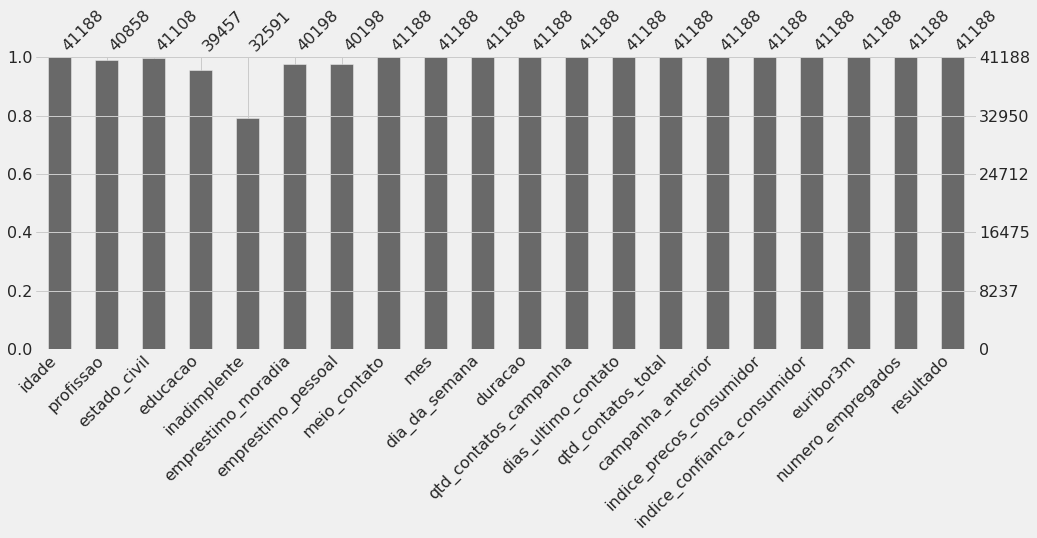

In [74]:
# Show missing by columns
msno.bar(df_callcenter,
         figsize=(15,5),
         labels=True)

<AxesSubplot:>

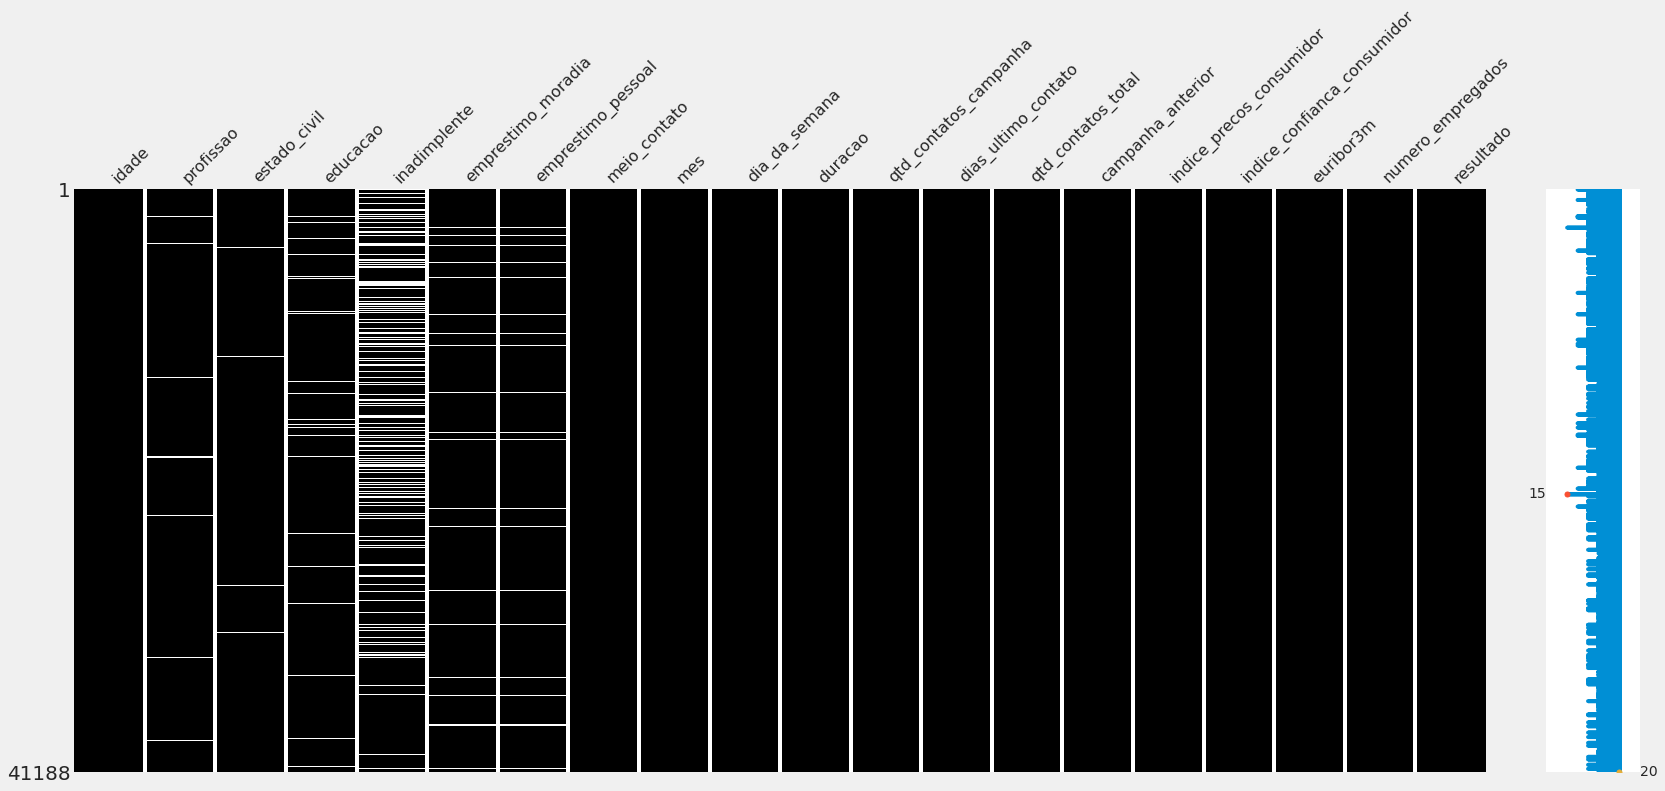

In [72]:
unsorted_data = msno.nullity_sort(df_callcenter)

msno.matrix(unsorted_data, 
            color=None)

**NOTE**
<br/>
- There are only missing values from **categorical data**
- If deleting the lines with missing data can be a great loss, as we have **30.8 %** lines showing this pattern but only **1.5 %** of the cells have _missing values_.

#### Missing Values Handling
##### Numeric Columns
- If that were the case, I would use the fill technique with the mean value of the column: `fillna`
- Adds less variance to the dataset than doing an interpolation

##### Categorical Columns
- I will use the fill technique with the column mode value: `fillna`

#### Applying Mode to Categorical Values

In [75]:
%%timeit

for column in df_callcenter[list_categorical_col]:
    df_callcenter[column].fillna(df_callcenter[column].mode()[0], inplace=True)

16 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [77]:
# Check result
df_callcenter.head(10)

,idade,profissao,estado_civil,educacao,inadimplente,emprestimo_moradia,emprestimo_pessoal,meio_contato,mes,dia_da_semana,duracao,qtd_contatos_campanha,dias_ultimo_contato,qtd_contatos_total,campanha_anterior,indice_precos_consumidor,indice_confianca_consumidor,euribor3m,numero_empregados,resultado
0,56,0.00,0.00,0.00,0.00,0.00,0.00,0,5,1,261,1,999,0,0,93.99,-36.40,4.86,5191.00,0
1,57,1.00,0.00,1.00,0.00,0.00,0.00,0,5,1,149,1,999,0,0,93.99,-36.40,4.86,5191.00,0
2,37,1.00,0.00,1.00,0.00,1.00,0.00,0,5,1,226,1,999,0,0,93.99,-36.40,4.86,5191.00,0
3,40,2.00,0.00,2.00,0.00,0.00,0.00,0,5,1,151,1,999,0,0,93.99,-36.40,4.86,5191.00,0
4,56,1.00,0.00,1.00,0.00,0.00,1.00,0,5,1,307,1,999,0,0,93.99,-36.40,4.86,5191.00,0
5,45,1.00,0.00,3.00,0.00,0.00,0.00,0,5,1,198,1,999,0,0,93.99,-36.40,4.86,5191.00,0
6,59,2.00,0.00,4.00,0.00,0.00,0.00,0,5,1,139,1,999,0,0,93.99,-36.40,4.86,5191.00,0
7,41,3.00,0.00,6.00,0.00,0.00,0.00,0,5,1,217,1,999,0,0,93.99,-36.40,4.86,5191.00,0
8,24,4.00,1.00,4.00,0.00,1.00,0.00,0,5,1,380,1,999,0,0,93.99,-36.40,4.86,5191.00,0
9,25,1.00,1.00,1.00,0.00,1.00,0.00,0,5,1,50,1,999,0,0,93.99,-36.40,4.86,5191.00,0


<br/>

### Duplicate Values
It's when the whole line is duplicated

In [80]:
# duplicated()

def check_quat_duplicated_data(df: pd.core.frame.DataFrame) -> None:
    """
    Check if contains duplicated data
    Mark duplicates as ``True`` if enough row equal
    Except for the first occurrence.    
    """
    duplicated = df.duplicated().sum()
    total_lines = df.shape[0]
    percentage = (duplicated/total_lines) * 100
    
    print("-"*25, "DUPLICATED DATA", "-"*25,)
    print("\nSHAPE of data: {}".format(df.shape[0]))
    print("TOTAL duplicated data: {}".format(duplicated))
    print("PERCENTAGE duplicated data: {:3.2} %".format(percentage)) 

In [81]:
check_quat_duplicated_data(df_callcenter)

------------------------- DUPLICATED DATA -------------------------

SHAPE of data: 41188
TOTAL duplicated data: 14
PERCENTAGE duplicated data: 0.034 %


#### Duplicate Values View

In [82]:
# Create dataframe only duplicated values
df_duplicated_value = df_callcenter[df_callcenter.duplicated(keep=False)]

display(df_duplicated_value.head(28))

,idade,profissao,estado_civil,educacao,inadimplente,emprestimo_moradia,emprestimo_pessoal,meio_contato,mes,dia_da_semana,duracao,qtd_contatos_campanha,dias_ultimo_contato,qtd_contatos_total,campanha_anterior,indice_precos_consumidor,indice_confianca_consumidor,euribor3m,numero_empregados,resultado
236,56,3.00,0.00,0.00,0.00,0.00,0.00,0,5,1,136,1,999,0,0,93.99,-36.40,4.86,5191.00,0
1265,39,3.00,0.00,2.00,0.00,0.00,0.00,0,5,4,124,1,999,0,0,93.99,-36.40,4.86,5191.00,0
1266,39,3.00,0.00,2.00,0.00,0.00,0.00,0,5,4,124,1,999,0,0,93.99,-36.40,4.86,5191.00,0
5664,56,3.00,0.00,0.00,0.00,0.00,0.00,0,5,1,136,1,999,0,0,93.99,-36.40,4.86,5191.00,0
12260,36,5.00,0.00,6.00,0.00,0.00,0.00,0,7,4,88,1,999,0,0,93.92,-42.70,4.97,5228.10,0
12261,36,5.00,0.00,6.00,0.00,0.00,0.00,0,7,4,88,1,999,0,0,93.92,-42.70,4.97,5228.10,0
14155,27,4.00,1.00,4.00,0.00,0.00,0.00,1,7,1,331,2,999,0,0,93.92,-42.70,4.96,5228.10,0
14234,27,4.00,1.00,4.00,0.00,0.00,0.00,1,7,1,331,2,999,0,0,93.92,-42.70,4.96,5228.10,0
16819,47,4.00,2.00,1.00,0.00,1.00,0.00,1,7,4,43,3,999,0,0,93.92,-42.70,4.96,5228.10,0
16956,47,4.00,2.00,1.00,0.00,1.00,0.00,1,7,4,43,3,999,0,0,93.92,-42.70,4.96,5228.10,0


#### Remove Duplicate Values

In [83]:
# drop_duplicates()

df_callcenter = df_callcenter.drop_duplicates(keep='first')
print("Shape dataframe = ", df_callcenter.shape)

Shape dataframe =  (41174, 20)


<br/>

### Type Conversion
- From here on, the dataframe can be of the type: `integer` because the missing values were treated.
- There are exceptions that continued to be a float, however limited to 2 digits after the comma:
  - `indice_precos_consumidor`
  - `indice_confianca_consumidor`
  - `euribor3m`

In [86]:
def handler_typing(df: pd.core.frame.DataFrame, 
                   type_col: str,
                   list_cont_feature: list,
                   *columns: list):
    for column in columns:
        if column in list_cont_feature:
            print(column)
            df[column] = df[column].map('{:,.2f}'.format) \
                        .astype(float) # object -> float
            continue
            
        df[column] = df[column].astype(dtype=type_col, errors='raise')
    
    return df.info(), display(df.head())

In [87]:
list_cont_feature = ['indice_precos_consumidor',
                     'indice_confianca_consumidor',
                     'euribor3m']

handler_typing(df_callcenter, 'int16', list_cont_feature, *list_columns)

indice_precos_consumidor
indice_confianca_consumidor
euribor3m
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41174 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        41174 non-null  int16  
 1   profissao                    41174 non-null  int16  
 2   estado_civil                 41174 non-null  int16  
 3   educacao                     41174 non-null  int16  
 4   inadimplente                 41174 non-null  int16  
 5   emprestimo_moradia           41174 non-null  int16  
 6   emprestimo_pessoal           41174 non-null  int16  
 7   meio_contato                 41174 non-null  int16  
 8   mes                          41174 non-null  int16  
 9   dia_da_semana                41174 non-null  int16  
 10  duracao                      41174 non-null  int16  
 11  qtd_contatos_campanha        41174 non-null  int16  
 12  dias_ultimo

,idade,profissao,estado_civil,educacao,inadimplente,emprestimo_moradia,emprestimo_pessoal,meio_contato,mes,dia_da_semana,duracao,qtd_contatos_campanha,dias_ultimo_contato,qtd_contatos_total,campanha_anterior,indice_precos_consumidor,indice_confianca_consumidor,euribor3m,numero_empregados,resultado
0,56,0,0,0,0,0,0,0,5,1,261,1,999,0,0,93.99,-36.40,4.86,5191,0
1,57,1,0,1,0,0,0,0,5,1,149,1,999,0,0,93.99,-36.40,4.86,5191,0
2,37,1,0,1,0,1,0,0,5,1,226,1,999,0,0,93.99,-36.40,4.86,5191,0
3,40,2,0,2,0,0,0,0,5,1,151,1,999,0,0,93.99,-36.40,4.86,5191,0
4,56,1,0,1,0,0,1,0,5,1,307,1,999,0,0,93.99,-36.40,4.86,5191,0


(None, None)

**NOTE**
<br/>
Dataframe decreased from **memory usage: 6.3 MB** to less than **3.0 MB**

<br/>

### Outliers
- The `pandas.describe()` function provides some information about boxplot.

In [88]:
df_callcenter.describe()

,idade,profissao,estado_civil,educacao,inadimplente,emprestimo_moradia,emprestimo_pessoal,meio_contato,mes,dia_da_semana,duracao,qtd_contatos_campanha,dias_ultimo_contato,qtd_contatos_total,campanha_anterior,indice_precos_consumidor,indice_confianca_consumidor,euribor3m,numero_empregados,resultado
count,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00,41174.00
mean,40.02,3.62,0.50,3.32,0.00,0.55,0.15,0.63,6.61,2.98,258.32,2.57,962.46,0.17,0.17,93.58,-40.50,3.62,5166.85,0.11
std,10.42,2.41,0.69,2.23,0.02,0.50,0.36,0.48,2.04,1.41,259.31,2.77,186.94,0.49,0.46,0.58,4.63,1.73,72.33,0.32
min,17.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,1.00,0.00,1.00,0.00,0.00,0.00,92.20,-50.80,0.63,4963.00,0.00
25%,32.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,5.00,2.00,102.00,1.00,999.00,0.00,0.00,93.08,-42.70,1.34,5099.00,0.00
50%,38.00,3.00,0.00,3.00,0.00,1.00,0.00,1.00,6.00,3.00,180.00,2.00,999.00,0.00,0.00,93.75,-41.80,4.86,5191.00,0.00
75%,47.00,4.00,1.00,6.00,0.00,1.00,0.00,1.00,8.00,4.00,319.00,3.00,999.00,0.00,0.00,93.99,-36.40,4.96,5228.00,0.00
max,98.00,11.00,2.00,7.00,2.00,1.00,1.00,1.00,12.00,5.00,4918.00,56.00,999.00,7.00,2.00,94.77,-26.90,5.04,5228.00,1.00


In [89]:
# quantile()

dict_quantile = {}


def calculate_quantile_by_col(df: pd.core.frame.DataFrame, *columns: list) -> None:
    """
    Calculate boxplot
    """
    for column in columns:
        dict_col = {}
       
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1  # Interquartile range

        dict_col[column] = {'q1': q1,
                            'q3': q3,
                            'iqr': iqr}
        # add dict column in principal dict
        dict_quantile.update(dict_col)


def calculate_fence(dict_col: pd.core.frame.DataFrame, *columns: list) -> None:
    for column in columns:
        dict_actual_col = dict_col[column]  # mount internal dict of dict_quantile
        dict_fence = {}  # auxiliar dict
        
        fence_low  = dict_actual_col['q1'] - 1.5 * dict_actual_col['iqr']
        fence_high = dict_actual_col['q3'] + 1.5 * dict_actual_col['iqr']
        
        dict_fence = {'fence_low': fence_low,
                     'fence_high': fence_high}
        
        # add dict column in principal dict
        dict_col[column].update(dict_fence)


def count_outlier(df: pd.core.frame.DataFrame, dict_quantile: dict, *columns: list):
    for column in columns:
        # mount internal dict of dict_quantile
        dict_actual_col = dict_quantile[column]

        outlier_less_q1 = (df[column] < dict_actual_col['fence_low']).sum()  # numpy.int64
        outlier_more_q3 = (df[column] > dict_actual_col['fence_high']).sum()  # numpy.int64
        total = outlier_less_q1 + outlier_more_q3
        
        dict_outlier = {'outlier_less_q1': outlier_less_q1,
                        'outlier_more_q3': outlier_more_q3,
                        'outlier_total': total}
        
        # add dict column in principal dict
        dict_quantile[column].update(dict_outlier)
        
    print("-"*25, "Dict Quantilie", "-"*25, end='\n\n')
    return pp.pprint(dict_quantile)


def check_quat_outlier(df: pd.core.frame.DataFrame, dict_quantile: dict, *columns: list):
    outlier_total = 0
    total_lines = df.shape[0]
    total_cells = np.product(df.shape)
    
    print("-"*15, "OUTLIERS", "-"*15)
    print("\nSHAPE of data: {}".format(df.shape[0]))
    print("\nPERCENTAGE outlier by column:") 
    
    # by column
    for column in columns:
        dict_actual_col = dict_quantile[column]  # mount internal dict of dict_quantile
        outlier_total += dict_actual_col['outlier_total']

        quant_outlier_by_col = dict_actual_col['outlier_total']
        percentage_outlier_by_col = (quant_outlier_by_col/total_lines) * 100
        
        print("{}: {:4.4} %".format(column, percentage_outlier_by_col)) 

        
    percentage_by_line = (outlier_total/total_lines) * 100
    percentage_by_cell = (outlier_total/total_cells) * 100
        
    print("PERCENTAGE outlier by line: {:2.3} %".format(percentage_by_line))
    print("PERCENTAGE outlier by cell: {:2.3} %".format(percentage_by_cell))
    print("\nTOTAL outlier: {}".format(outlier_total))

In [90]:
# run
calculate_quantile_by_col(df_callcenter, *list_columns)

calculate_fence(dict_quantile, *list_columns)

count_outlier(df_callcenter, dict_quantile, *list_columns)

------------------------- Dict Quantilie -------------------------

{   'campanha_anterior': {   'fence_high': 0.0,
                             'fence_low': 0.0,
                             'iqr': 0.0,
                             'outlier_less_q1': 0,
                             'outlier_more_q3': 5625,
                             'outlier_total': 5625,
                             'q1': 0.0,
                             'q3': 0.0},
    'dia_da_semana': {   'fence_high': 7.0,
                         'fence_low': -1.0,
                         'iqr': 2.0,
                         'outlier_less_q1': 0,
                         'outlier_more_q3': 0,
                         'outlier_total': 0,
                         'q1': 2.0,
                         'q3': 4.0},
    'dias_ultimo_contato': {   'fence_high': 999.0,
                               'fence_low': 999.0,
                               'iqr': 0.0,
                               'outlier_less_q1': 1515,
                   

In [91]:
check_quat_outlier(df_callcenter, dict_quantile, *list_columns)

--------------- OUTLIERS ---------------

SHAPE of data: 41174

PERCENTAGE outlier by column:
idade: 1.137 %
profissao: 9.113 %
estado_civil:  0.0 %
educacao:  0.0 %
inadimplente: 0.007286 %
emprestimo_moradia:  0.0 %
emprestimo_pessoal: 15.17 %
meio_contato:  0.0 %
mes:  0.0 %
dia_da_semana:  0.0 %
duracao: 7.196 %
qtd_contatos_campanha: 5.843 %
dias_ultimo_contato: 3.68 %
qtd_contatos_total: 13.66 %
campanha_anterior: 13.66 %
indice_precos_consumidor:  0.0 %
indice_confianca_consumidor: 1.083 %
euribor3m:  0.0 %
numero_empregados:  0.0 %
resultado: 11.27 %
PERCENTAGE outlier by line: 81.8 %
PERCENTAGE outlier by cell: 4.09 %

TOTAL outlier: 33690


#### Outliers Graphical Analysis

In [92]:
def plot_box_plot(df: pd.core.frame.DataFrame, data_set_name: str, xlim=None):
    """
    Creates a seaborn boxplot including all dependent
    
    Args:
    data_set_name: Name of title for the boxplot
    xlim: Set upper and lower x-limits
    
    Returns:
    Box plot with specified data_frame, title, and x-limits 
    """
    fig, ax = plt.subplots(figsize=(18, 10))

    if xlim is not None:
        plt.xlim(*xlim)
    
    plt.title(f"Horizontal Boxplot {data_set_name}")
        
    plt.ylabel('Dependent Variables')
    plt.xlabel('Measurement x')
    ax = sns.boxplot(data = df,
                    orient = 'h', 
                    palette = 'Set2',
                    notch = False, # box instead of notch shape 
                    sym = 'rs')  # red squares for outliers

    plt.show()

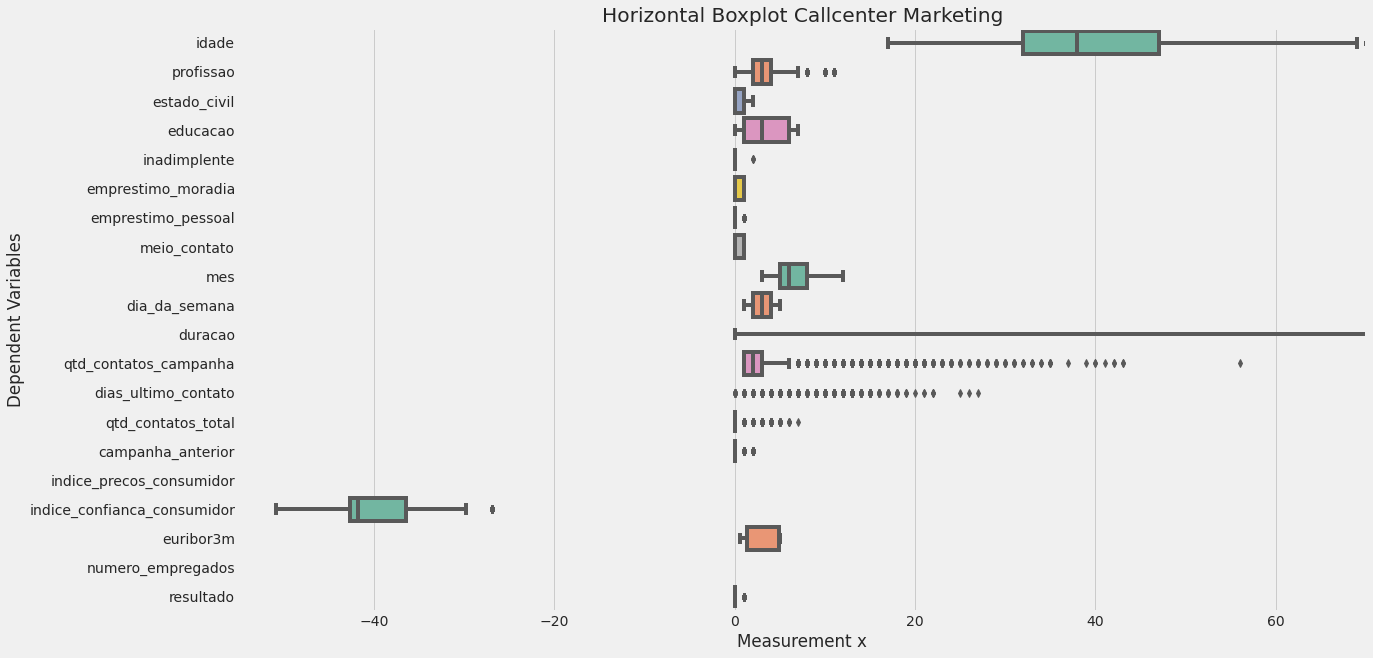

In [93]:
plot_box_plot(df_callcenter, 
              'Callcenter Marketing', 
              (-55, 70))

The boxplots were very dispersed, better to analyze separately.

<br/>


In [94]:
def show_boxplot(df, *columns):
    for column in columns:
        plt.figure (figsize = (17, 1)) 
        sns.boxplot(x=df[column],
                    width=0.5,
                    linewidth=1.0,
                    showfliers=True)

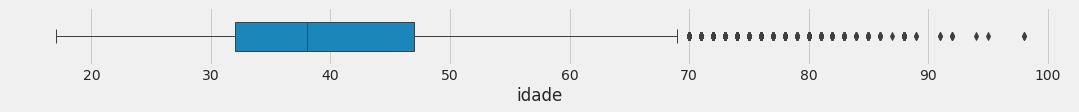

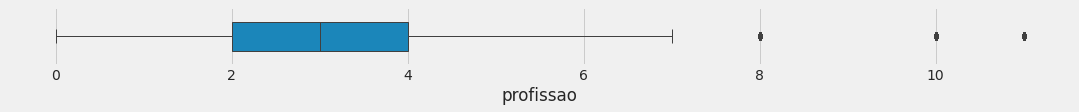

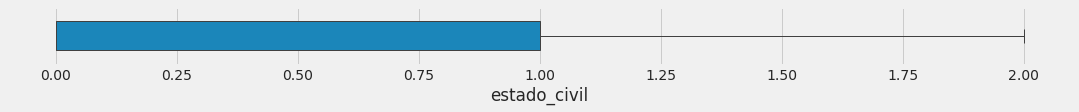

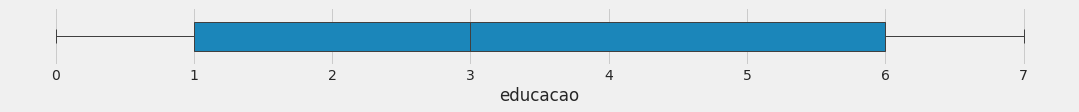

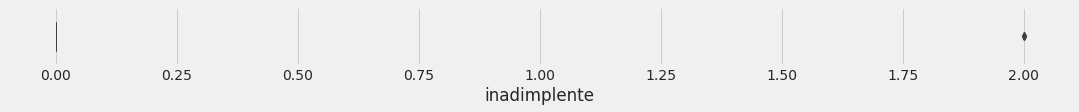

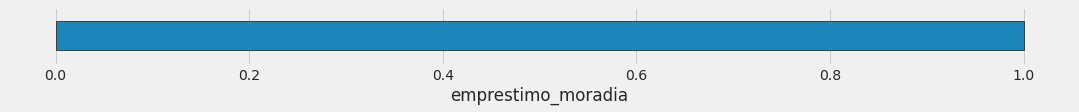

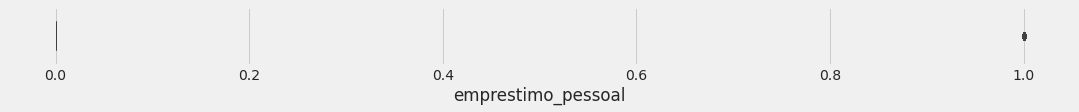

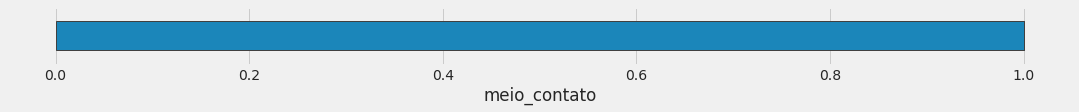

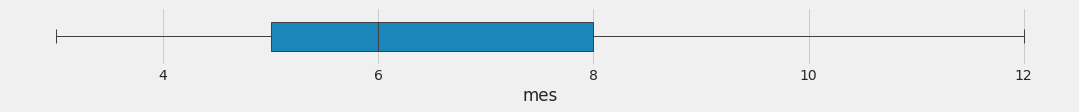

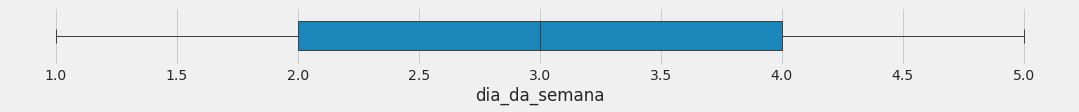

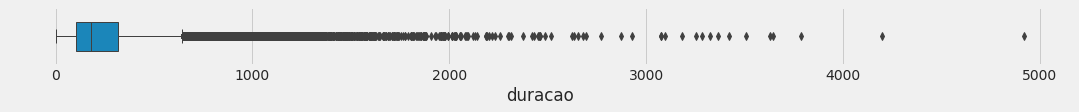

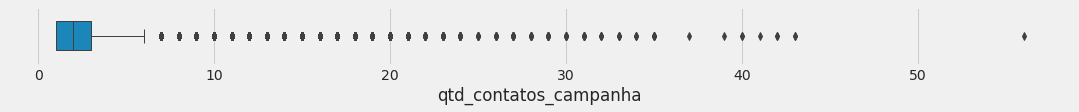

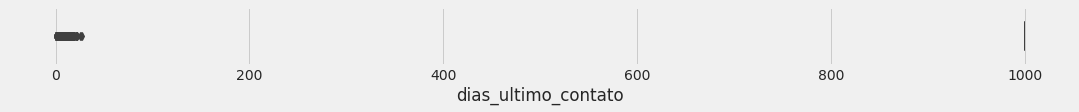

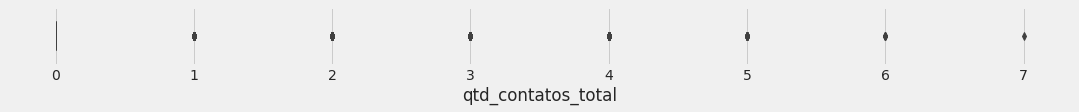

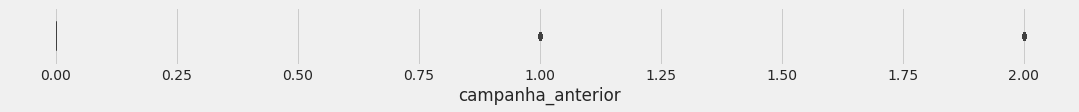

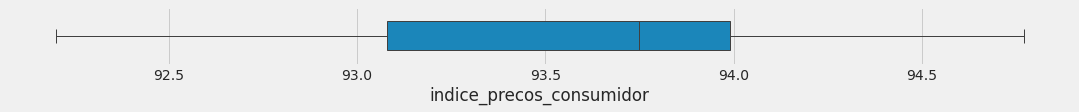

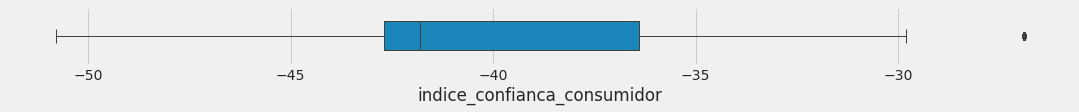

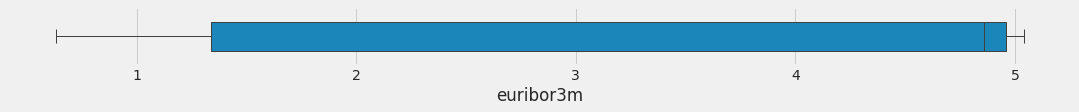

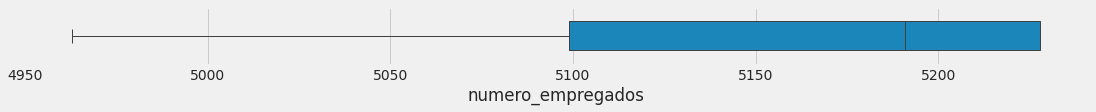

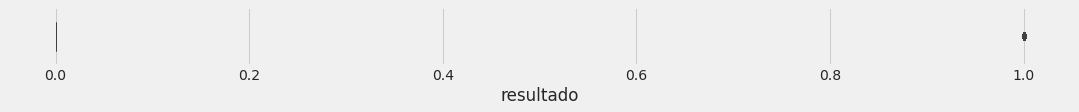

In [95]:
show_boxplot(df_callcenter, *list_columns)

**NOTES**
- The variable `idade` has outliers, however it is not necessary to treat.

- `profissao`, `estado civil`, `educacao`, `meio_contato`, `mes`, `dia_semana` e `campanha_anterior` they are variables that come from categorical values.

- `inadimplente`, `emprestimo_pessoal`, `emprestimo_moradia` and `resultado` they are categorical variables that were yes and no. Besides these, the variable `campanha_anterior` is a case that presents only 3 possible values. For these variables, it is not possible to treat outliers.

- `duracao` show **2963 outliers**.
- Analyzing the boxplot, apply the **rescale** technique.
   - Analyze what is the minimum and maximum time for `result == yes`.
   - Test the hypothesis: if `duracao == 0`, then `result == no`.
   <br/>
     NOTE: if a POSITIVE result, it could be a result of a previous campaign

- `qtd_contatos_campanha` show **2406 outliers**. 
  - Analyzing the boxplot, the **rescale** technique should be applied.

- `qtd_contatos_total` show **5625 outliers**.
  - In this case, any contact > 0 has already been considered outlier. So, it is worth testing the hypothesis: if `qtd_contatos_total == 0`, then `NEGATIVE result`.
  <br/>
  NOTE: `qtd_contatos_total` is the number of contacts made before this campaign and for this client

- `dias_ultimo_contato` it has an outlier because it was registered in the dataset for 999 days in cases where there is no forecast of the last contact. So that becomes an outlier that needs to be handle. However, the interpretation of the metadata in this column says that they are values that you have no idea of when the last contact was made. Therefore, these values are `missing values` !
  - In this case, I will replace the value 999 by 0 as this will make a distribution closer to normal.

- `indice_confianca_consumidor` show **446 outliers**.
  - There are few outliers, so I will not apply any outlier handle technique.

- `indice_precos_consumidor`, `euribor3m`, `numero_empregados` do not have outliers.

#### Minimum and Maximum Time Analysis for `resultado == sim`

In [96]:
df_min = df_callcenter[['resultado','duracao']].sort_values(['duracao'])

print('Minimum duration in sec: \n{}\n'.format(df_min.query('resultado == 1').iloc[0]))
print('Maximum duration in sec: \n{}'.format(df_min.query('resultado == 1').iloc[-1]))

Minimum duration in sec: 
resultado     1
duracao      37
Name: 24016, dtype: int16

Maximum duration in sec: 
resultado       1
duracao      4199
Name: 22192, dtype: int16


- After 37 seconds, the first positive result appears
- Up to 4199 seconds a positive result can occur

I believe that removing values between these duration limits can affect training, so I will keep it.

#### Handle Outliers

- **Hypothesis**:
If `duracao == 0`, than `resultado NEGATIVO`

In [56]:
# 'resultado': {'nao': 0, 'sim': 1}

df_min = df_callcenter[['duracao','resultado']]
len(df_min.query('duracao == 0 & resultado == 1'))

0

There are no cases where the call lasted 0 minutes and the result was positive.

So, from that, **the outliers are confirmed**. I'm going to eliminate the tuples that present the condition of the raised hypothesis.

All rows that have `duracao == 0` will be deleted.

In [97]:
print(f'Rows before operation = {df_callcenter.shape[0]}')

cond_duracao = (df_callcenter.duracao > 0) 
df_callcenter = df_callcenter[cond_duracao]

print(f'Rows after operation = {df_callcenter.shape[0]}')

Rows before operation = 41174
Rows after operation = 41170


- **Hypothesis**: If `qtd_contatos_total == 0`, than `resultado NEGATIVO`.

In [98]:
df_min = df_callcenter[['resultado','qtd_contatos_total']]

len(df_min.query('resultado == 1 & qtd_contatos_total == 0'))

3140

At first, this hypothesis was not valid, even if `qtd_contatos_total == 0`, there are POSITIVE results. This means that there must be at least 1 contact from `qtd_contatos_total`
<!-- 
A princípio esta hipótese não foi válida, ou seja, mesmo que `qtd_contatos_total == 0`, há resultado POSITIVOS. Isso significa que deve haver pelo menos 1 contato da `qtd_contatos_total` -->

- **rescale**: `duracao`, `qtd_contatos_campanha`

In [99]:
def plot_distribuition(df: pd.core.frame.DataFrame, column: str):
    plt.figure()
    df[column].plot.hist(alpha=0.5, color='blue')
    plt.title(f"Distribuição da Coluna {column}")
    plt.show()

    sns.boxplot(x=df[column],
                width=0.5,
                showfliers=True)

In [100]:
def apply_log(df: pd.core.frame.DataFrame = None,
              fix: int = 0,
              type_col: 'number' = 'int16',
              column: str = None):
    
    skew_before = df[column].skew()
    df[column] = [np.log(x + fix).astype(type_col) for x in df[column]]
    skew_after = df[column].skew()
    
    return f'Skew before = {skew_before} -> Skew after = {skew_after}'

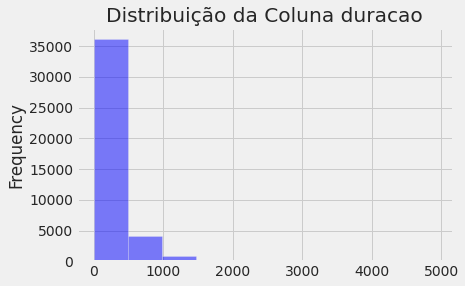

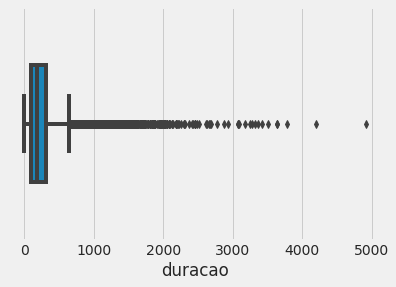

In [101]:
plot_distribuition(df_callcenter, 'duracao')

In [102]:
apply_log(df = df_callcenter,
          fix= 1,
          type_col = int,
          column = 'duracao')

'Skew before = 3.2628673006168816 -> Skew after = -0.36106321738750846'

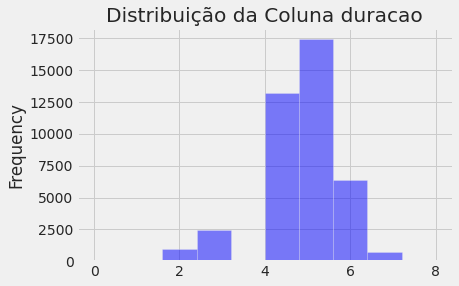

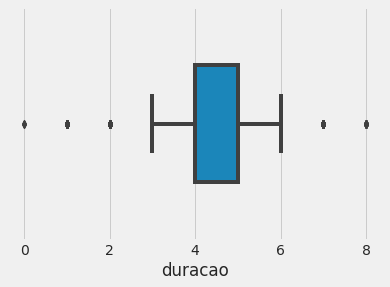

In [103]:
plot_distribuition(df_callcenter, 'duracao')

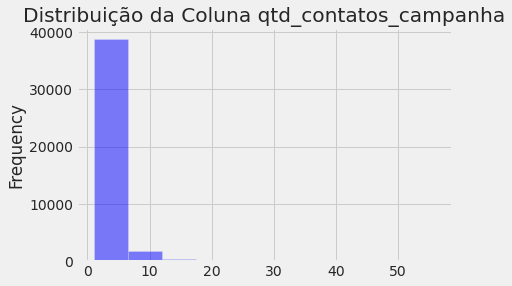

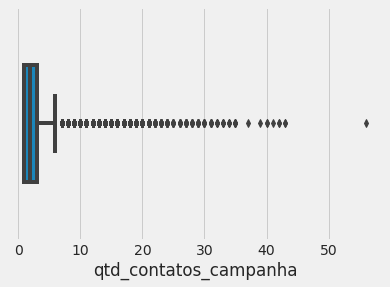

In [104]:
plot_distribuition(df_callcenter, 'qtd_contatos_campanha')

In [105]:
apply_log(df = df_callcenter,
          type_col = int,
          column = 'qtd_contatos_campanha')

'Skew before = 4.762798594693606 -> Skew after = 1.468090764742922'

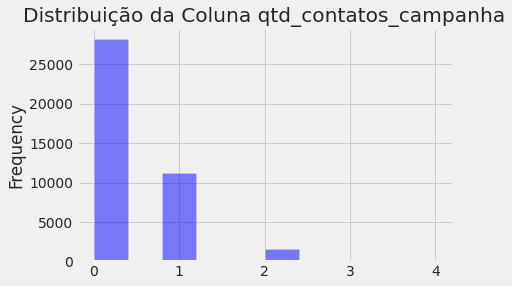

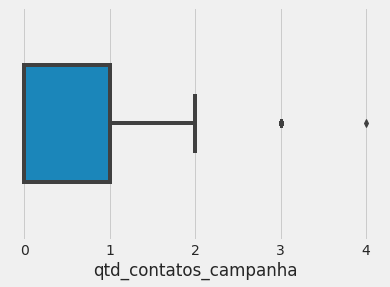

In [106]:
plot_distribuition(df_callcenter, 'qtd_contatos_campanha')

- `dias_ultimo_contato` I will switch valus
  - In this case, I will replace the value 999 with 0 as this will leave a distribution closer to normal.

In [107]:
df_callcenter['dias_ultimo_contato'] = df_callcenter['dias_ultimo_contato'].replace(999, 0)

count_row_999 = len(df_callcenter.query('dias_ultimo_contato == 999'))
print(f'Rows with (dias_ultimo_contato == 999), after operation = {count_row_999}')

Rows with (dias_ultimo_contato == 999), after operation = 0


---

## **Save Clean Data**

In [108]:
def save_data_clenning(df: pd.core.frame.DataFrame,
                       path: str = 'data/cleansing/') -> None:
    df.to_csv(path_or_buf = path,
              sep = ',',
              index = False,
              encoding = 'utf8')
    
    return "saved data!"

In [109]:
save_data_clenning(df = df_callcenter,
                   path = 'data/cleansing/callcenter_marketing_clenning.csv')

'saved data!'